# Pairs Trading Strategy Design & Backtest v2025

## Part 0: Data Download & Preparation

In [1]:
# import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

# Custom modules to make notebook more organized
# run `%pip install -e ".."` in this kernel once if imports fail

from cointegration_analysis.analytics.cointegration import (
    johansen_sensitivity_summary,
    adf_results,
    kpss_results,
    engle_granger,
    engle_granger_bidirectional,
    za_test,
    analyze_regression_var_summary,
    analyze_johansen_triples,
    analyze_ecm_timeslices,
    analyze_error_correction_model,
    johansen,
 )

from cointegration_analysis.analytics.plotting import (
    analyze_pairs_nb,
    plot_systematic_performance,
    plot_kalman_beta_evolution,
 )

from cointegration_analysis.analytics.backtesting import (
    adaptive_cointegration_analysis,
    backtest_pair_strategy,
    compute_rolling_beta,
    compute_rolling_sharpe,
    rolling_cointegration_analysis,
    run_cv_over_pairs,
    run_systematic_backtest,
    summarize_cv,
 )


# Configuration to make table displays more readable
pd.set_option('display.float_format', '{:.4f}'.format)
pd.set_option('display.max_columns', None)
pd.set_option('display.width', None)

ASSET_DATA_DIR = "../data"
BENCHMARK_PATH = f"{ASSET_DATA_DIR}/sp500_benchmark_data.csv"

**Pairs Selection Rationale**

To start off I will take the apprach of downloading a larger set of pairs (and some potential tripples) to then perform a variety of tests on as a funneling approach to end up with the target 2-3 pairs for further study. The selected pairs (/tripples) were chosen based on own experience of the market and an understanding of pairs potentially linked by economic, quant, and event factors. I have tried to include a diverse set of asset classes and potential linkages, commodities, rates/FX, volatility, indices, equities, and sector ETFs. This broad and large set of pairs provide a good starting point and allows us to explore cointegrated relationship across a diverse range of assets. Below shows the initial list of potential cointegrated relationships to explore, given that the source of these are my own experience following the market, these are based on my own biases and there is no guarantee they are actually cointegrated, which makes it all the more important we have a thorough approach to test these relationships.

**Pair/Triple Summaries**

- Precious Metals Triple (Gold, Silver, Platinum): These metals often move together due to their roles as stores of value and industrial inputs. Cointegration could be driven by  by macroeconomic cycles and investor sentiment.
- Oil Pair (WTI, Brent): WTI and Brent oil are different grades of oil and often trade closely together, supply/demand shocks can often temporarily dislocate their prices but they have a tendency to move back together to a more stable spread.
- Agri Pair (Corn, Soybean): Corn and soybean prices are linked by crop rotation, weather patterns, and global trade flows.
- Yield Pair (US 10Y Yield, UK Gilts ETF): US and UK government bond yields are influenced by global interest rate cycles and monetary policy often moving together.Dislocations can last a long time since rate decisions are not made that frequently which could limit the potential trading opportunities.
- Currency Pair (AUD/USD, CAD/USD): Both AUD and CAD are commodity linked currencies with their exchange rates shaped by similar macroeconomics.
- Volatility Pair (VIX, VIXY): The VIX index and VIXY ETF track US equity volatility the relationship is affected by futures curve dynamics and market stress regimes.
- EU Index Pair 1 (CAC 40, DAX): French and German equity indices are closely tied through European economic integration and cross border corporate activity.
- EU Index Pair 2 (IBEX 35, FTSE MIB): Similarly Spanish and Italian indices reflect Southern European market conditions.
- French Banking Pair (BNP Paribas, Societe Generale): Two major French banks with overlapping business models and exposure to the same regulatory environment.
- Fast Fashion Pair (Inditex, H&M): Leading European fast fashion retailers whose performance is shaped by consumer trends and global supply chains.
- German Auto Triple (VW, Mercedes, BMW): Germanys top automakers, sharing industry cycles, regulatory changes, and technological shifts.
- Investor AB Pair (Investor A, Investor B): Two share classes of the same Swedish investment company, expected to track closely due to identical underlying assets but with different voting rights.
- VW Porsche Pair (VW, Porsche AG): Linked through ownership structure and shared automotive sector exposure, VW owns circa 75% of Porsche.
- Semiconductor Pair (ASML, Infineon): European semiconductor firms with cointegration possible due to sector wide demand and supply chain factors.
- Sector ETF Pair (XLRE, XLU): US real estate and utilities ETFs both considered defensive sectors and often moving together during risk off periods.


In [2]:
# Uncomment the line below to download data
#end_date, start_date = datetime.now(), end_date - timedelta(days=5*365)

asset_groups = {
    "precious_metals_triple": ["GC=F", "SI=F", "PL=F"],    # Gold, Silver, Platinum Futures
    "oil_pair": ["CL=F", "BZ=F"],                          # WTI, Brent Crude Futures
    "agri_pair": ["ZC=F", "ZS=F"],                         # Corn, Soybean Futures
    "yield_pair": ["^TNX", "IGLT.L"],                      # US 10Y Yield, iShares UK Gilts ETF
    "currency_pair": ["AUDUSD=X", "CADUSD=X"],             # AUD/USD, CAD/USD
    "volatility_pair": ["^VIX", "VIXY"],                   # US VIX Index vs. Short-Term VIX Futures ETF
    "eu_index_pair_1": ["^FCHI", "^GDAXI"],                # CAC 40, DAX
    "eu_index_pair_2": ["^IBEX", "FTSEMIB.MI"],            # IBEX 35, FTSE MIB
    "fr_banking_pair": ["BNP.PA", "GLE.PA"],               # BNP Paribas, Societe Generale
    "fast_fashion_pair": ["ITX.MC", "HM-B.ST"],            # Inditex, H&M
    "german_auto_triple": ["VOW3.DE", "MBG.DE", "BMW.DE"], # VW, Mercedes, BMW
    "investor_ab_pair": ["INVE-A.ST", "INVE-B.ST"],       # Investor A, Investor B
    "vw_porsche_pair": ["VOW3.DE", "P911.DE"],             # VW, Porsche
    "semiconductor_pair": ["ASML.AS", "ASMI.AS"],          # ASML, ASM International
    "sector_etf_pair": ["XLRE", "XLU"]                    # Real Estate ETF, Utilities ETF
}

# Load data from CSV files
all_data = {}
benchmark = pd.read_csv(BENCHMARK_PATH, index_col=0, parse_dates=True)


for group_name in asset_groups.keys():
    filename = f"{ASSET_DATA_DIR}/{group_name}_data.csv"
    df = pd.read_csv(filename, index_col=0, parse_dates=True)
    all_data[group_name] = df

## Part I: Pairs trade design & Preparatory cointegration analysis

Task 1: Recode regression estimation in matrix form. Implement Vector Autogregression specification tests for stability check using eigenvalue and identify optimal lag p using AIC/BIC

Task 2: Implement Engle-Granger (EG) for each pair using Augmented DF with lag=1 for the first part. For the second part write a short analysis including of the EC-term.

Task 3: Extend EG with a mean-reversion evaluation, enabeling trade design to enter on bounds $µ_e ± Zσ_eq$ and exit on $e_t$ reverting to the level $µ_e$.

Task 4: Optimize Z by e.g. vary in increments, producechart/table analyzing N trades and P&L for each level.

Task 5:  Present a short discussion of thoughts on structural breaks for the chosen asset groups. 

#### Task 1: Regression in matrix form, VAR optimal lag $p$, & Eigenvalues

For each pair we have (or for triples add columns accordingly):
$$
\mathbf{Pair} \,=\, 
\begin{pmatrix}
\vdots & \vdots & \vdots\\
y_{t} & x^{(1)}_{t} & x^{(2)}_{t}\\
\vdots & \vdots & \vdots
\end{pmatrix}
$$

We can specify $y$ to be the $T×1$ target vector and $X$ the $T×k$ design matrix (with intercept).The first column of $1$ is the intercept, $k$ is the number of regressors.:

$$
\mathbf{y} \,=\, \begin{pmatrix}y_1\\ \vdots\\ y_T\end{pmatrix} \in \mathbb R^{T\times1},\quad
\mathbf{X} \,=\, \begin{pmatrix}
1 & x^{(1)}_1 & x^{(2)}_1 & \cdots \\ 
\vdots & \vdots & \vdots & \\
1 & x^{(1)}_T & x^{(2)}_T & \cdots 
\end{pmatrix} \in \mathbb R^{T\times k}
$$

Our OLS estimator and fitted values then becomes:
$$ 
\hat{\boldsymbol\beta}= (\mathbf{X}^\top \mathbf{X})^{-1}\,\mathbf{X}^\top\,\mathbf{y},\quad
\hat{\mathbf{y}}=\mathbf{X}\,\hat{\boldsymbol\beta},\quad 
\hat{\boldsymbol\varepsilon}=\mathbf{y}-\hat{\mathbf{y}}
$$
We can look at the  $R^2$ as a crude indicator of co movement as an initial indicator of relationships to look into further for cointegration, but to confirm cointegration we must test the asset pars further.

In [3]:
#Implementation in cointegration_test.py that will be used in later calls.

# def matrix_ols_regression(y, X):
#        XTX = X.T @ X
#        XTX_inv = np.linalg.inv(XTX)
#        XTY = X.T @ y
#        beta = XTX_inv @ XTY
#        return beta

When looking at the relationship between two time series there can be dynamic depenence that can add explanatory power to our model, or flipping the perspective we want to avoid residual autocorrelation so we don't miss out on signal. We can frame this relationship as there being $p$ previous periods we want to take into account in our model, in our case we have daily data so $p$ indicates how many days of data we want to incude in our model. If we have to few lags we bias inference while too many bias inference.

We can use a Vector Autoregressive model with order $p$ $VAR(p)$, we can express each variable (asset) as a linear function of its own $p$ past values, past $p$ values of other variables in the system, as well as an error term. With intercept $c$ and estimates by multivariate OLS $VAR(p)$ for $n$ series:
$$
\mathbf{Y}_t \,=\,\mathbf{c} + A_1\,\mathbf{Y}_{t-1} + \cdots + A_p\,\mathbf{Y}_{t-p} +  \varepsilon_t
$$

To find optimal lag $p$ we have several options we can use, AIC, BIC or even HQIC. These varyingly balance fit and parsimony for a VAR with log-likelihood $\ell_p$ and parameters $K=n^2p+n$:
$$
\begin{aligned}
\mathrm{AIC}(p) &= -2\,\ell_p + 2K,\\
\mathrm{BIC}(p) &= -2\,\ell_p + K\,\ln(T-p),\\
\mathrm{HQIC}(p) &= -2\,\ell_p + 2K\,\ln\!\big(\ln(T-p)\big).
\end{aligned}
$$
We will include all three in our analysis so we can then compare all 3 potential lags with the basecase of lag 1.

With optimal lag chosen we can assess stability with eigenvalues via the companion matrix:
$$
\mathcal{F} = \begin{pmatrix}
A_1 & A_2 & \cdots & A_{p-1} & A_p \\
I_n & 0   & \cdots & 0        & 0   \\
0   & I_n & \cdots & 0        & 0   \\
\vdots &   & \ddots &          & \vdots\\
0   & 0   & \cdots & I_n      & 0
\end{pmatrix} \in \mathbb R^{np\times np}
$$
Stability if and only if all eigenvalues satisfy $max|\lambda_i|<1$ (see VAR section for notation).

In [4]:
# analyze_regression_var_summary performs a regression analysis on the provided asset groups and r^2 is calculated
# AIC/BIC/HQIC are calculated using the statsmodels VAR implementation. Eigenvalues are calculated using the best AIC fit lag
reg_var_summary = analyze_regression_var_summary(all_data)
reg_var_summary

,group,r_squared,best_aic,best_bic,best_hqic,eigenvalues
0,precious_metals_triple,0.8442,7,1,2,0.466 0.466 0.537 0.537 0.559 0.559 0.601 0.60...
1,oil_pair,0.9916,9,2,2,0.653 0.653 0.693 0.693 0.709 0.709 0.743 0.74...
2,agri_pair,0.8049,1,1,1,0.981 0.996
3,yield_pair,0.9335,3,2,2,0.182 0.271 0.277 0.277 0.992 0.997
4,currency_pair,0.8363,4,1,2,0.245 0.351 0.351 0.412 0.412 0.413 0.989 0.996
5,volatility_pair,0.2209,8,3,3,0.582 0.603 0.603 0.604 0.604 0.659 0.664 0.66...
6,eu_index_pair_1,0.5988,1,1,1,0.994 1.002
7,eu_index_pair_2,0.9550,1,1,1,0.990 1.000
8,fr_banking_pair,0.7718,1,1,1,0.996 1.005
9,fast_fashion_pair,0.2451,2,1,1,0.026 0.043 0.989 0.999


Only 6 of the asset groups have the same optimal AIC, BIC and HQIC (all of those 6 have optimal lags at 1 for all methods), the varying lags of the other asset groups could be an indication of shifting relationship across the series for those assets. In terms of Eigenvalues almost no values are below 1, no asset group has all eigenvalues below 0. However a lot of asset groups have eigenvalues just around 1. In terms of $r^2$ there seems to be very strong relations in the oil, yield, EU index pair 2, and the Investor AB pair. Except for investor (and partly german auto makers) the equity groups had low $r^2$. Also volatility had a surprislingly low $r^2$. Non of these tests are themselves conclusive regarding cointegration of the asset groups but they give us some nuance and context that will be helpful in our further exploration of these relationships.

#### Task 2: Engle-Granger (+ bonus Johansen) & analysis of EC term

With the initial exploration done we can move on with explicitly testing for stationarity using ADF and KPSS which will allow us to move on to the Engle-Granger procedure (as well as the Johansen procedure for triples). The following decision thresholds will be used for the 4 tests:

| Test       | Null (H₀)                               | Alternative (H₁)          | α-Level |
|------------|-----------------------------------------|---------------------------|---------|
| ADF        | Non-stationarity (unit root)            | Stationarity              | 5%      |
| KPSS       | Stationarity                            | Unit root                 | 5%      |
| EG Step 2  | No cointegration (β_ec=0)               | Cointegration (β_ec≠0)    | 5%      |
| Johansen   | ≤ r cointegration vectors               | > r cointegration vectors | 5%      |

Let's now go over the 4 tests in detail before we impplement them. We will start with the 2 tests for staionarity.

Each asset individually is tested for stationarity using the Augmented Dickey–Fuller (ADF) and KPSS tests. A time series $X_t$ is (weakly) stationary if its mean, variance, and autocovariance do not change over time. Financial series are often not stationary and exhibit unit roots. A process is said to be integrated of order one $I(1)$ if differencing once yields a stationary series. Here we will be differencing by looking at all assets in the given group at a time, for pairs we look at this using Engle Granger and if we have more assets we can use the Johansen procedure. If the differences series is stationary we say it is $I(0)$.

ADF tests the null of a unit root (non-stationarity) against the alternative of stationarity, via the regression:
$$
\Delta X_t = \gamma X_{t-1} + \sum_{i=1}^{p} \phi_i \, \Delta X_{t-i} + \varepsilon_t,
$$  
where $\Delta X_t = X_t - X_{t-1}$. If $X_t$ has a unit root, then $\gamma = 0$. If $X_t$ is stationary we expect $\gamma < 0$. The test statistic for $\hat{\gamma}$ is compared to ADF $α$ critical value of 5%.

KPSS reverses the hypotheses: $H_0$: stationary (around a level or trend vs. $H_1$: unit root. It assesses whether residuals from a regression on a constant or trend exhibit a random-walk component. If ADF rejects $H_0$ (unit root) and KPSS fails to reject $H_0$ (stationarity) both point to stationarity, giving us confidence we have a stationary series. Conflicting results could suggest trend stationarity or mixed evidence, this would warrante further investigate specification (e.g., include a trend), lag length, or structural breaks.


In [5]:
# ADF & KPSS are calculated using the statsmodel implementation, 
# helper functions to structure the data are in cointegration_analysis.analytics.cointegration
data_pairs = [(group, asset, df[asset]) for group, df in all_data.items() for asset in df.columns]

results = pd.DataFrame([
    {
        'Group': group,
        'Asset': asset, 
        'ADF_pval': adf_results(series)['pvalue'],
        'KPSS_pval': kpss_results(series)['pvalue']
    }
    for group, asset, series in data_pairs
])

results['Status'] = np.where(
    (results['ADF_pval'] < 0.05) & (results['KPSS_pval'] >= 0.05), 'Stationary',
    np.where(
        (results['ADF_pval'] >= 0.05) & (results['KPSS_pval'] < 0.05), 'Non-stationary', 
        'Mixed'
    )
)

results

,Group,Asset,ADF_pval,KPSS_pval,Status
0,precious_metals_triple,GC=F,0.9991,0.0100,Non-stationary
1,precious_metals_triple,PL=F,0.1353,0.0724,Mixed
2,precious_metals_triple,SI=F,0.9636,0.0100,Non-stationary
3,oil_pair,BZ=F,0.2190,0.0100,Non-stationary
4,oil_pair,CL=F,0.1344,0.0100,Non-stationary
5,agri_pair,ZC=F,0.3894,0.0100,Non-stationary
6,agri_pair,ZS=F,0.4923,0.0100,Non-stationary
7,yield_pair,IGLT.L,0.4165,0.0100,Non-stationary
8,yield_pair,^TNX,0.4666,0.0100,Non-stationary
9,currency_pair,AUDUSD=X,0.5150,0.0100,Non-stationary


As expected non of the individual assets have strong evidence of stationarity. However a handful of assets passed 1 of the tests but not the others, assets trading flat, which is common for volatility index, commodities and even some stocks is not uncommon over some time periods so it is not too surprising we are getting the mixed result. Overall we can draw the conclusion there is no strong evidence of stationarity in any of the individual assets for the given time period. This leads us into the EG (and Joahnson procedure), can we now difference these assets to create combined series that is stationary and therefore cointegrated.

##### Engle-Granger Cointegration Test (Pairs)

Engle Granger (EG) tests of a linear combination of two (or more) nonstationary series is stationary i.e., whether they are cointegrated and share a common stochastic trend. As per the exam instructions we will use maxlag=1 but it will also be interesting to compare lag $p$ 1 with the different max lags we got from our VAR analysis previously.

If $Y_t$ and $X_t$ each are $I(1)$. If there exists $\beta$ such that $u_t = Y_t - \beta X_t$ is $I(0)$, then $Y_t$ and $X_t$ are cointegrated. To test this we use the EG two step procedure:

1. Estimate the cointegrating relationship
   $$
   Y_t = c + \beta X_t + u_t,
   $$  
   using OLS to obtain $\hat{c} $, $\hat{\beta}$, and residuals $\hat{u}_t$. We can interprete the $\hat{\beta}$ as the hedge ratio.

2. Test residual stationarity 
   Apply the ADF to test $\hat{u}_t$. If $\hat{u}_t$ is stationary $I(0)$ we conclude cointegration between $Y_t$ and $X_t$. And we use the same EG specific critical values from above of 5%.

A couple of caveats with EG is that results can differ depending on which variable is treated as dependant in the OLS. We are also limited by one cointegration vector and need to use Johansen if we want to test for more.

In [6]:
# Runs EG tests for each par, baseline with maxlag=1 and alternatives using VAR-selected lags (AIC/BIC/HQIC)
# Stores outputs  all_results, then flattens them into comparison_data with lag, hedge ratio (beta), p-value.
all_results = {}
pair_groups = reg_var_summary[reg_var_summary['group'].str.endswith('_pair')].copy() # only pairs

for _, row in pair_groups.iterrows():
    group = row['group']
    df = all_data[group]
    y, x = df.columns[:2]
    lag_lengths = {'aic': row['best_aic'], 'bic': row['best_bic'],  'hqic': row['best_hqic']}
    pair_results = {'baseline': engle_granger(df, y, x, maxlag=1)}
    
    # Add alternative lag tests only where different from baseline
    for criterion, lag in lag_lengths.items():
        if lag != 1:
            pair_results[criterion] = engle_granger(df, y, x, maxlag=lag)
    
    all_results[group] = pair_results

comparison_data = [
    {'Pair': group, 'Criterion': criterion,
        'Max Lag': result['maxlag'], 'Hedge Ratio': result['beta'],
        'P-value': result['eg_pvalue'], 'Cointegrated': result['eg_pvalue'] <= 0.05
    }
    for group, results in all_results.items()
    for criterion, result in results.items()
]

pd.DataFrame(comparison_data)

,Pair,Criterion,Max Lag,Hedge Ratio,P-value,Cointegrated
0,oil_pair,baseline,1,1.0253,0.0000,True
1,oil_pair,aic,9,1.0253,0.0003,True
2,oil_pair,bic,2,1.0253,0.0000,True
3,oil_pair,hqic,2,1.0253,0.0000,True
4,agri_pair,baseline,1,0.4899,0.0145,True
5,yield_pair,baseline,1,-1.0173,0.1538,False
6,yield_pair,aic,3,-1.0173,0.1905,False
7,yield_pair,bic,2,-1.0173,0.1655,False
8,yield_pair,hqic,2,-1.0173,0.1655,False
9,currency_pair,baseline,1,1.2746,0.0216,True


The oil pair exhibits cointegration across all lags, the agriculture pair had optimal p=1 for all methods and also shows cointegration on $p=1$. Currency pair shows cointegration on some lags not others. Volatility pair also shows cointegration across all $p$. The rest of the pairs show no cointegration, the lack of cointegration for the different Investor AB share classes is surprising, each different shareclass entitle the holder to the same stake in the company, only voting rights are different, my initial hypothesis would have been that this one would have the strongest cointegration, it would be interesting to dive deeper into this pair to investigate why above tests did not find cointegration to see if there really is no cointegration or if it is possible to use different model parameters to prove the cointegration but that is outside the scope of this paper. For now, oil, agri, currency and volatility are the 4 pairs that look most promising.

Next lets analyze the error correction terms using the Error Correction Model (ECM), we estimate the ECM parameters to quantify adjustment to equilibrium deviations.

For a cointegrated series $Y$ and $X$ with residual $u_{t-1}=Y_{t-1}-\beta X_{t-1}$ the discrete ECM is:

$$\Delta Y_t = \alpha\,u_{t-1} + \sum_{i=1}^{p-1} \phi_i\,\Delta Y_{t-i} + \sum_{i=1}^{p-1} \psi_i\,\Delta X_{t-i} + \eta_t,$$

the $\alpha$ is the error correction coefficient (which we can interprete as the adjustment speed back to equilibrium).

In [7]:
# For the 4 promising pairs compute the EG spread and fit an ECM ovia analyze_error_correction_model.
pairs = ['oil_pair', 'agri_pair', 'currency_pair', 'volatility_pair']
ecm_results = {}

for pair in pairs:
    df = all_data[pair]
    y, x = df.columns[:2]
    eg = engle_granger(df, y, x)
    ecm_results[pair] = analyze_error_correction_model(df[y], df[x], eg['spread'])

pd.DataFrame(ecm_results).T

,ecm_coeff,ecm_pvalue
oil_pair,-0.0827,0.0000
agri_pair,-0.0144,0.0027
currency_pair,-0.0156,0.0012
volatility_pair,-0.0059,0.0000


All pairs show negative coefficients which confirms cointegration (mean reversion), the higher (absolute) the value the quicker the mean reversion so we can see that oil reverts relativly quickly while volatility is the slowest to revert (we could interprete this as volatility clustering, periods of high/low periods tend to last a while). We can further the ECM analysis by splitting the dataset into subperiods to check if the coefficients stay the same across different subperiods. Below code splits the data into 5 equal length periods and performs the same ECM analysis. For each time slice run OLS dep ~ 1 + regression to get the local cointegrating residual $u_t$, then run ECM $Δdep_t ~ c + [Δreg_t] + u_{t-1}$. The coefficient on $u_{t-1}$ is the ecm_coeff and its p-value is ecm_pvalue. It tries both directions ($y|x$ and $x|y$) and returns the direction with stronger adjustment (prefers negative coeff with lower p-value). But first we will test the triples to see if we should keep any of them for further analysis.

We can test the triples with the the Johansen procedure tests by estimating a VECM and the rank of its long run coefficient matrix $\Pi = \alpha\beta'$. If $\Pi$ has reduced rank $r$, there are $r$ independent cointegrating vectors. We use two likelihood ratio tests, the trace test and the maximum eigenvalue test to determine $r$. 

The trace test checks the null hypothesis that there are at most $r$ cointegrating relations against the alternative of more than $r$. It computes $-T \sum_{i=r+1}^{n}\ln(1-\hat\lambda_i)$, which accumulates the eigenvalues $\hat\lambda$ beyond rank $r$, if this exceeds the critical value we reject $H_0$ and conclude that at least $r+1$ cointegrating vectors exist.

The max-eigen test considers the null of exactly $r$ cointegrating vectors Vs $r+1$ and focuses on the next eigenvalue $-T\ln(1-\hat\lambda_{r+1})$. By increasing $r$ from 0 upward and applying these tests we find the estimated cointegration rank $\hat r$.

With Johansen test we get an estimate of the cointegrating vector $\beta$ via the top eigenvector which we can use to form a stationary spread e.g. $w_1 X_{1t} + w_2 X_{2t} + w_3 X_{3t}$ that mean reverts. For below implementation we use the optimal lag length $p$ identified from the previous VAR analysis.

In [8]:
# Runs Johansen tests on triples returning rank, eigenvector norm, spread vol.
johansen_df = analyze_johansen_triples(all_data)
johansen_df

,triple,n_assets,data_points,n_coint_relations,first_eigenvec_norm,spread_vol
0,precious_metals_triple,3,1305,0,0.6662,NaN
1,german_auto_triple,3,1305,0,0.2251,NaN


There are no cointegrated relationships from the Johansen test, to explore why this might we can run some sensativity analysis to get any idea of why got this result. Using deterministics det_order $∈ {-1, 0, 1, 2}$ and trying all three different AIC/BIC/HQIC optimal lags we get 12 different specifications per windows we also use weekly sampling (W-FRI) to reduce roll/noise, log-levels to stabilize variance subperiod slices to mitigate regime breaks again using r > 0 at 5% as the critical decision threshold.

In [9]:
# Runs Johansen sensitivity, sweeps det_order {-1,0,1,2} and VAR lags (AIC/BIC/HQIC), windows/sampling by periods.
# Implemented in cointegration_analysis.analytics.cointegration via repeated coint_johansen calls

summary = johansen_sensitivity_summary(all_data)
summary

 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number  4 had an illegal value
 ** On entry to DLASCL parameter number 

,triple,window,rank>0,total,summary
4,german_auto_triple,H1,0,12,0/12
5,german_auto_triple,H2,8,12,8/12
3,german_auto_triple,full,0,12,0/12
1,precious_metals_triple,H1,8,12,8/12
2,precious_metals_triple,H2,6,12,6/12
0,precious_metals_triple,full,3,12,3/12


The german auto tripple shows does not show anything for the first or full window but does show rank > 1 for the second time window. This means there likeley was a structural change, trends in EV, auto worker strikes and tarrifs could mean the tripples were strongly cointegrated in the second time window whereas the first time window might have been driven more by company specific factors. The precious metal tripple shows stronger indication of cointegration, both window periods show stronger cointegration 6/8 than the full sample that showed 3, this is also an indication that  there are probably structural changes happening and that the full sample dilutes the signal. Given the weak signs of cointegration for triples we will not keep any of them for further analysis and will instead continue with the pairs we have left. We had 4 pairs with strong sign of cointegration but it would also be interesting to look at subperiod relatinships for those pairs, since we already have strong indication of cointegration for the whole period we will break down the slices here more granularly by doing 5 slices, approx 1 year per slice.

In [10]:
# For each pair analyze_ecm_timeslices runs 5 slice ECM on the first two columns
# Implemented in cointegration_analysis.analytics.cointegration by re-estimating the cointegrating residual per slice, 
# fitting dY ~ c + dX + u_{t-1} in both directions and reporting ecm_coeff/p-values.
timeslice_tables = {
    pair: analyze_ecm_timeslices(all_data[pair].iloc[:, 0], all_data[pair].iloc[:, 1], periods=5)
    for pair in pairs
}

pd.concat(timeslice_tables, axis=0)

P1      P2      P3      P4      P5
oil_pair        ecm_coeff   0.0630 -0.2331 -0.0522 -0.2390 -0.1515
                ecm_pvalue  0.5321  0.0182  0.5974  0.0366  0.2168
agri_pair       ecm_coeff  -0.0332 -0.0332 -0.0080 -0.0387  0.0007
                ecm_pvalue  0.1241  0.0993  0.6082  0.1278  0.9529
currency_pair   ecm_coeff  -0.0107 -0.0212 -0.0392 -0.0306 -0.0896
                ecm_pvalue  0.5596  0.4893  0.1007  0.1211  0.0016
volatility_pair ecm_coeff   0.0332 -0.0694  0.0374 -0.0093 -0.1140
                ecm_pvalue  0.0087  0.0069  0.0384  0.4522  0.0331

Oil shows strong mean reversion with episodes of accelerated adjustment (P2, P4). Agri was small but not significant. Currency adjustment is present throughout but much stronger from P3 onward, full sample is diluted by the weaker first two slices. Volatility (VIX vs VIXY) is mixed with a couple of periods not showing mean reversersion full sample probably underestimates speed because per slice estimation captures time-varying β and dynamics.

The slice re-estimate of the cointegrating allow the adjusting leg to switch (direction pick), and include ΔX. This reduces misspecification and reveals time variation in both β and adjustment speed so per slice alphas are stronger and more consistent. To further focus the analysis we will drop the volatility pair and continue with the other 3 pairs.

In [11]:
selected = ['oil_pair', 'currency_pair', 'agri_pair']

##### Task 3: Extending EG with a third step for mean reversion evaluation


We will extend EG with a trading rule, enter at $μ_e ± Z·σ_e$ and exit when the spread reverts to $μ_e$. For each pair we run EG and get the hedge ratio β and residual spread $S_t = Y_t - β X_t$. We can then use the Ornstein-Uhlenbeck (OU) process SDE:

$$dS_t=\theta(\mu-S_t)\,dt+\sigma\,dW_t,$$
which we discretize to an AR(1):
$$S_{t+1}=\mu_e+\rho(S_t-\mu_e)+\varepsilon_t,\quad \rho=e^{-\theta\Delta t}.$$

We fit the AR(1) model to $S_t$ to estimate $\rho$, set $\theta = -\ln(\rho)$, and compute $\mu_e$ and $\sigma_e$ to define the Z bands. Our signal is:
$$z_t = \frac{S_t - \mu_e}{\sigma_e}.$$

With the signal in place we set the trading rules. Entry:
- Short spread when $z_t \ge Z$ (short Y, long $\beta$ units of X).
- Long spread when $z_t \le -Z$ (long Y, short $\beta$ units of X).

Exit:
- Close when $|z_t| \le 0$ (i.e., on reversion to $\mu_e$).

##### Task 4: Find optimal Z

We want to find some optimal value of $Z$ which we can do simply by sweeping $Z \in [0.5, 3.0]$ in steps of 0.1. The implementation below normalizes PnL on $\Delta z_t$ to make pairs comparable and applies a cost of 20 bps on position changes. We report $N$ trades, cumulative PnL, and average PnL and select $Z$ by maximizing cumulative PnL.

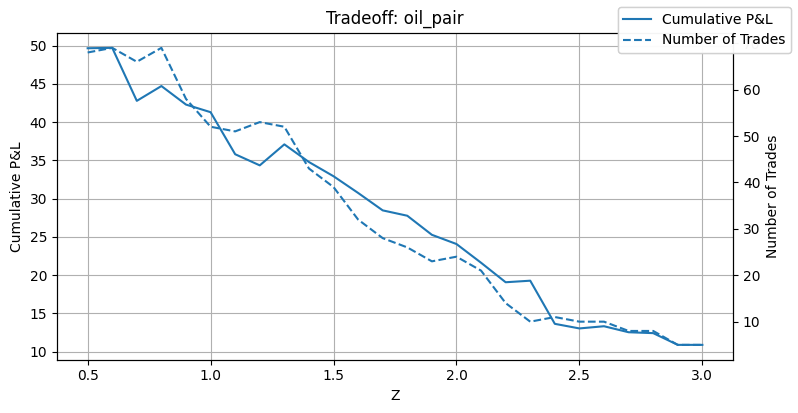

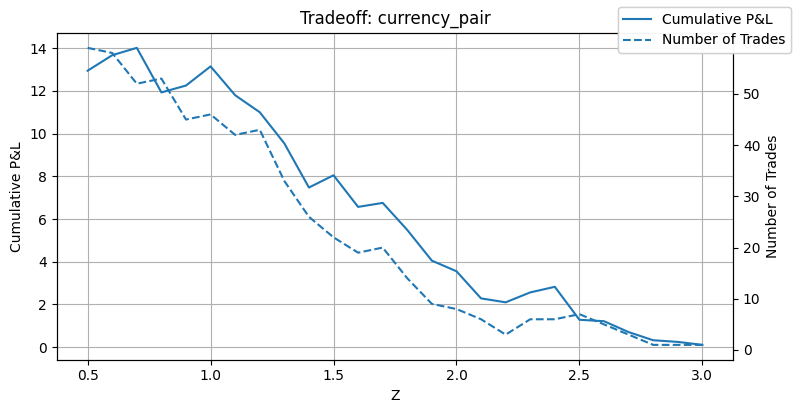

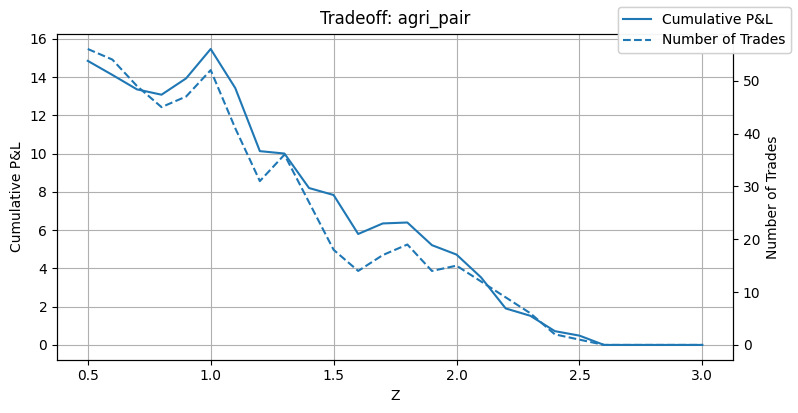

,pair,best_Z,N_trades,cum_PnL,avg_PnL,theta,half_life
0,oil_pair,0.6000,69,49.6970,0.7202,0.0809,8.5646
1,currency_pair,0.7000,52,14.0157,0.2695,0.0180,38.4805
2,agri_pair,1.0000,52,15.4650,0.2974,0.0180,38.4040


In [12]:
# Sweeps Z ∈ [0.5, 3.0] by 0.1 using analyze_pairs_nb simulates band-entry/exit on EG spreads with cost and optional z-normalization
# Plot utilities live in cointegration_analysis.analytics.plotting (hedge β, spread and z-score, tally trades, pick best_Z)
summary_df, opt_tables = analyze_pairs_nb(
    all_data, selected, 
    Z_min=0.5, Z_max=3.0, dZ=0.1, 
    cost=0.002,
    normalize=True
)
summary_df

Results are in normalized (z) units (matters for agri pair which would otherwise not be comparable) so magnitudes are comparable across asset classes. Oil shows tightest optimal band and highest trade count showing strong, frequent mean reversion. N_trades vs Z fall steeply peaks around 0.5–0.6 then declines as signals get too sparse.
Currency shows moderate edge, more cost-sensitive. Optimal Z slightly wider than oil.
graph shows a little hump near 0.7. Agri pair needs wider entry at 1 to overcome noise/roll effects, edge is comparable to currency once normalized.

##### Task 5: Structural break risk discussion

Structural breaks matter because our cointegration and meanm reversion framework (EG residual stationarity, ECM, and OU/AR(1) dynamics) assumes stable long run equilibrium and adjustment speed. Our ECM time slice study already gave some proof of time varying relations. Oil showed periodic acceleration (P2, P4), currency strengthened after P2, and volatility (VIX–VIXY) had a small but significant full sample α while slices were consistently stronger. Shifts like these imply that $β$, $μ_e$, $σ_e$, and $ρ$ can drift across regimes, changing OU half life and Z-band effectiveness. For oil structural breaks could arise from things such as logistics and policy changes (pipeline flows, export/import policies, OPEC shifts) that permanently alter the differential relation. AUD and CAD currency policy divergence and terms-of-trade shocks could decouple the commodity currency linkage, this commodity related economy relationship could change as dependence on certain commodies shift. VIX–VIXY term structure regimes (contango/backwardation) could change ETF roll-yield drag and tracking, weakening residual stationarity even if short windows still look mean reverting.

We can use tools such as ZA (Zivot–Andrews) to identify and flag endogenous breakpoints. ZA reestimates EG/β and OU/AR(1) parameters on rolling windows (as in our time-slice ECM) so $μ_e$ and $σ_e$ for $z_t$ adapt and conduct walk forward Z-sweeps since $Z_best$ can drift with costs and adjustment speed. We could then include guards like halting trading when EG residual ADF p-values rise, widening $Z_exit$ temporarily if half-life lengthens, and using a time-varying β (e.g., Kalman) to cushion slow drifts. This would keep our trading strategy aligned with the evolving equilibrium identified by the EG/ECM and OU mappings.

In [13]:
# Computes bidirectional EG spread, then run Zivot–Andrews structural break tests (level and trend) on the spread
# Implemented in cointegration_analysis.analytics.cointegration; engle_granger_bidirectional runs EG both directions and returns the better residual/spread

results = []
for pair in selected:
    df = all_data[pair]
    y, x = df.columns
    eg = engle_granger_bidirectional(df, y, x)
    spread = eg['spread'].dropna()
    results.append(za_test(spread, model='level').assign(pair=pair))
    results.append(za_test(spread, model='trend').assign(pair=pair))

pd.concat(results, ignore_index=True)

,stat,pvalue,breakpoint,break_date,model,pair
0,-6.6454,0.0002,507,2022-07-20,level,oil_pair
1,-6.6274,0.0010,507,2022-07-20,trend,oil_pair
2,-4.9824,0.0307,189,2021-04-30,level,currency_pair
3,-5.0019,0.0625,189,2021-04-30,trend,currency_pair
4,-4.8639,0.0440,1086,2024-10-08,level,agri_pair
5,-5.4457,0.0170,1086,2024-10-08,trend,agri_pair


The ZA results indicate strong evidence of stationarity with a structural break for oil_pair under both specifications (level and trend) on 2020-09-09 suggesting a robust break in the mean and not undermined by adding a trend. For currency_pair stationarity is supported only under a level break but not when a trend break implying the break is primarily in the intercept. For agri_pair both models show a breakpoint at the start (0) implying an early-sample structural shift. August/September was an intense period for the world and the market, covid was a major factor, it is perhaps to too surprising that the the strongest breaks in this timeframe occured roughly at the same time for all three pairs.

## Part II: Backtesting

Task 6: ML/Scikit-learn inspirired backtesting of trading strategy e.g. split data into train/test set.

Task 7: Systematic backtesting, produce drawdown, rolling sharpe, and rolling beta (vs S&P 500) plots and discuss plots.

Task 8: Discuss benefits and disadvantages of regular re-estimation of cointegrated
relationships: 5-8 months rolling window shifting by 10-15 days.

Optional/bonus task: Kalman filter for adaptive re-estimation of EG step 1

##### Task 6: Splitting train/test data and backtesting trading strategy

The strategy models a stationary spread between two assets by running an EG step 1 regression on training window to estimate $α$ and $β$ forming the spread $St = Yt −β̂Xt - α̂ $. The spread is standardized on the train set to a Z-score using $μ̂e$ and $σ̂e$, and a threshold rule triggers trades: short-spread when $z ≥ Z$ and long-spread when $z ≤ −Z$, exiting on reversion toward zero. Returns are computed from β‑neutral spread returns with a one bar execution lag and transaction costs (20 bps) applied to position changes. All parameters are fit on train and held fixed in the test. Z comes from a prior analysis of best Z to avoid contaminating the test.

Data are split chronologically (e.g., 60/40) to show the estimation versus evaluation windows. Cross‑validation then applies a walk‑forward, time‑series scheme with 5 (n_splits) folds, preserving order and avoiding leakage. Each fold trains on an earlier slice and tests on the subsequent block, performance metrics such as Sharpe, returns, max drawdown, and trade counts are calculated per fold.

Across folds, several elements change because they are re‑estimated on the folds train window, $α$, $β$, and the z‑scaling $μ$ and $σ$. Signals, positions, and metrics vary with the train/test dates. Z threshold, cost model trading rules and fold scheme are constant.

In [14]:
# Run 5 fold time-series CV best_Z with 20 bps cost returns cv_results and fold level artifacts.

cv_results, cv_artifacts = run_cv_over_pairs(
    all_data, 
    selected, 
    summary_df.set_index("pair")["best_Z"].to_dict(), 
    n_splits=5,
    return_artifacts=True,  # Collect artifcats to mae task 7 stitching easier
    transaction_costs=0.002
)

cv_results

,pair,split,z_threshold,hedge_ratio,total_return,sharpe_ratio,max_drawdown,num_trades,train_start,train_end,test_start,test_end
0,oil_pair,0,0.6000,1.0249,0.0468,2.2416,-0.0311,30,2020-08-10,2023-08-09,2023-08-10,2023-11-06
1,oil_pair,1,0.6000,1.0242,0.0121,0.4730,-0.0254,38,2020-08-10,2023-09-21,2023-09-22,2023-12-19
2,oil_pair,2,0.6000,1.0234,0.0302,1.7574,-0.0191,34,2020-08-10,2023-11-03,2023-11-06,2024-01-31
3,oil_pair,3,0.6000,1.0232,0.0246,1.5459,-0.0187,35,2020-08-10,2023-12-18,2023-12-19,2024-03-14
4,oil_pair,4,0.6000,1.0228,0.0432,2.6011,-0.0117,44,2020-08-10,2024-01-30,2024-01-31,2024-04-26
5,currency_pair,0,0.7000,1.2847,-0.0054,-0.3901,-0.0194,21,2020-08-10,2023-08-09,2023-08-10,2023-11-06
6,currency_pair,1,0.7000,1.3327,0.0155,1.0043,-0.0162,39,2020-08-10,2023-09-21,2023-09-22,2023-12-19
7,currency_pair,2,0.7000,1.3735,-0.0148,-1.4408,-0.0155,26,2020-08-10,2023-11-03,2023-11-06,2024-01-31
8,currency_pair,3,0.7000,1.3789,0.0004,0.0461,-0.0133,36,2020-08-10,2023-12-18,2023-12-19,2024-03-14
9,currency_pair,4,0.7000,1.3873,0.0036,0.4008,-0.0130,28,2020-08-10,2024-01-30,2024-01-31,2024-04-26


In [15]:
# Aggregatting folds to per pair averages/totals

cv_summary_all = summarize_cv(cv_results, all_data, selected)

cv_summary_all

,,total_return_mean,total_return_std,sharpe_ratio_mean,sharpe_ratio_std,max_drawdown_mean,num_trades_mean,half_life,theta
pair,z_threshold,,,,,,,,
agri_pair,1.0000,0.0202,0.0257,0.6725,1.0687,-0.0373,24.4000,38.4040,0.0180
currency_pair,0.7000,-0.0001,0.0112,-0.0759,0.9179,-0.0155,30.0000,38.4805,0.0180
oil_pair,0.6000,0.0314,0.0141,1.7238,0.8116,-0.0212,36.2000,8.5646,0.0809


The walk-forward results show stable and strong performance for the oil pair with modest parameter drift. The hedge ratio is tight at 1.025 down 1.023, consistently high Sharpe per folds with the exection of the second fold, low drawdowns. Trades are frequent at 36 per fold and rise a bit in later folds. Returns per fold are at mean 2.72%, std 1.46% indicating the regime over the CV horizon favors quick reversion with limited tail risk.

Currency pair shows increasing hedge ratios across folds, β 1.285 to 1.387, indicating a slowly evolving equilibrium between AUD/CAD. Performance is weak with Sharpe mean -0.05 (std 0.89) but with the smallest drawdowns of the three pairs. Fold returns are volatile with periods of negative returns.  Trade counts are balanced averaging 30 per fold suggesting signals are present but weaker than oil.

The Agri pair shows β trends up 0.543 tp 0.569 and the first three folds post solid returns but then turns negative for the next fold and small return for the last one. Drawdowns are the highest of the pairs and trades fewer at an average of 24.

Oil is the most stable and profitable across folds, currency has virtually no return over the period, and agri is opportunistic with one potential weak regime detection indicating more friction in the cointegration structure.

##### Task 7: Systematic backtesting, produce drawdown, rolling sharpe, and rolling beta (vs excess S&P 500) plots and discuss plots


For Task 7 we will stitch together the CV fold results from Task 6 to create continuous time-series for systematic analysis. This approach reuses existing CV fold results, stitches folds by time sequence, inserts NaN markers at boundaries to break rolling statistics,   connects performance across folds, and computes continuous performance on Sharpe ratio, drawdowns.

For beta and Sharpe windows, returns are aligned on the strategy index. Rolling window length $W = 126$ trading days ($\approx 6$ months).

Equity curve shows cumulative return processed from simple daily returns. Set $V_0 = 1$, $V_t = \prod_{k=1}^{t} (1 + r_k)$, and cumulative return $C_t = V_t - 1 = \prod_{k=1}^{t} (1 + r_k) - 1$.

Drawdown is computed from the running peak of the wealth curve. Define $P_t = \max_{1 \le k \le t} V_k$. Drawdown at time $t$ (non‑positive) is $DD_t = (V_t - P_t)/P_t \le 0$. Max drawdown over the period is $MDD = \min_t DD_t$. Plotted as percentage ($\times 100$).

Rolling Sharpe ratio (annualized). Over a rolling window of size $W$:
$$\mu_t = \frac{1}{W} \sum_{k=t-W+1}^{t} r_k,$$
$$\sigma_t = \sqrt{\frac{1}{W-1} \sum_{k=t-W+1}^{t} (r_k - \mu_t)^2}.$$
Assuming $r_f \approx 0$ and 252 trading days/year, the rolling Sharpe is $Sharpe_t = \sqrt{252}\,\mu_t / \sigma_t$.

Rolling beta vs excess S&P 500. Align benchmark returns to strategy dates: $b_k$ aligned with $r_k$. Over a rolling window $W$, we compute:
$$\mathrm{Cov}_t = \frac{1}{W-1} \sum_{k=t-W+1}^{t} (r_k - \bar r_t)(b_k - \bar b_t),$$
$$\mathrm{Var}_{b,t} = \frac{1}{W-1} \sum_{k=t-W+1}^{t} (b_k - \bar b_t)^2.$$
The rolling market beta is the OLS slope $\beta_t = \mathrm{Cov}_t / \mathrm{Var}_{b,t}$, equivalent to the slope in $r_k = \alpha + \beta\, b_k + \varepsilon_k$ over the window (intercept $\alpha$ is estimated but does not affect $\beta$). The plot includes reference lines at 0 and $\pm 0.1$. NaNs at boundaries prevent windows from spanning folds.

In [16]:
# Stitch CV fold into a continuous backtest 
stitched_results, systematic_df = run_systematic_backtest(cv_artifacts, selected, summary_df)

systematic_df

KeyError: 'Requested level (pair) does not match index name (None)'

In [ ]:
# Load S&P 500 excess returns for beta calculation
sp500_returns = benchmark.iloc[:, 0].pct_change().dropna()

# Plot systematic performance on strategy return, drawdown, rolling sharpe, and rolling beta
rolling_df = plot_systematic_performance(
    stitched_results=stitched_results,
    selected_pairs=selected,
    benchmark_returns=sp500_returns,
    compute_rolling_sharpe=compute_rolling_sharpe,
    compute_rolling_beta=compute_rolling_beta
)

The oil pair shows a steady climb in returns with short pauses, total return similair to agricultural pair. Drawdowns are shallow and frequent, mostly contained within about −2% to −3%. Rolling Sharpe is strong early then dips for a prolonged period to return strong toward the end where it hoovers around 2. Rolling beta is near zero overall with one brief spike above 0.03 around early March that quickly re‑centers.

The currency Pair the returns largely flat with small round trips, no persistent trend. Drawdown is moderate but controlled roughly within −2.5%.
Rolling Sharpe is mostly around 0, but often even negative, signal appears episodic rather than persistent. Rolling beta is near zero and stable, good market neutrality no little payoff.

The agricultural pair has the deepest drawdown of the three (down to ~−5%), consistent with a noisier spread. Rolling Sharpe stays around 1.5 for the first 2/3 but then dips down to 0.5. Rolling beta moves a bit but stays close to 0.

Agricultural and oil pair show decent gains but currency stayed flat. All 3 pairs achieved reasonable market neutrality.

##### Task 8: Discuss benefits and disadvantages of regular re-estimation of cointegrated relationships: 5-8 months rolling window shifting by 10-15 days.

Regularly re-estimating cointegration makes our strategy adaptable relationships aren’t permanent, pair that was cointegrated last year might drift due to structural changes (industry shifts, company news, macro factors). By recalibrating the cointegrating coefficient and spread periodically the strategy can capture regime changes.  This means if the cointegration weakens or breaks, the model will detect it (e.g. an increased ADF p-value) and adjust or exit potentially avoiding prolonged drawdowns. Rolling estimation also keeps the hedge ratio and spread distribution updated so trading signals (like Z-scores) reflect current volatility and mean levels rather than stale histrical trends.

Frequent re-estimation has disadvantages, it introduces noise and uncertainty, using only 5–8 months of data can make the estimated β unstable, and small sample effects might falsely indicate cointegration This overfitting risk means we might trade random patterns. When β changes often the definition of the spread shifts a trade opened under the old parameters might need rebalancing or could become misaligned under the new parameters, incurring extra transaction costs and complexity. Rolling strategy can lead to higher turnover and can cause whipsaw if not carefully managed. Switching models can create whipsaw in cointegration tests themselves (one window passes, the next fails, etc.), making it harder to stick to a pair. Thus, while rolling re-estimation keeps the model current, it must be balanced against the potential for increased noise and costs.

Below implementation shows some of these potential downsides and benefits, the Oil strategy benefits from the rolling trading window but the currency and agricultural pair strategies turn unstrable, especially the agricultural pair turns from modest gains to big losses with the rolling window.

In [ ]:
# rolling_cointegration_analysis  compare static vs rolling-window strategies using best_Z

comparison_df = rolling_cointegration_analysis(all_data, selected, summary_df.set_index("pair")["best_Z"].to_dict())

comparison_df

##### Bonus task Kalman

In [ ]:
# adaptive_cointegration_analysis  estimate time varying β (Kalman) per pair

kalman_analysis = adaptive_cointegration_analysis(all_data, selected, summary_df.set_index("pair")["best_Z"].to_dict())
plot_kalman_beta_evolution(kalman_analysis, selected)

The adaptive EG Step 1 via a Kalman filter shows that the cointegrating weight (β) is time varying. For the oil pair β evolves somwhat smoothly with low volatility, an initial hump but overall quite stable which is consistent with a stable long run cointegration with limited structural change, this supports tighter entry bands. The currency pair exhibits more pronounced drift, especially in the beginning indicating a rapidly shifting equilibrium that then stabilizes. The agricultural pair also has a large drift which indicates regime changes and a less reliable long run relation over the sample.

Monitoring β path,  level, slope (drift), and variance can be sort of health check for cointegration. Rising β volatility or persistent drift can be treated as warnings to widen Z‑bands, shorten re‑estimation windows, or temporarily suspend trades until stability returns. When β is stable with low variance a simpler static EG  may be enough and reduces model complexity.